# AOS_ts_wep_tests

Re-doing tests for ts_wep:

[wepControllerMonolithicEimg](#wepControllerMonolithicEimgwepControllerMonolithicEimg)

[wEPCalculation](#wEPCalculation)

[camIsrWrapper](#camIsrWrapper)

[butlerWrapper](#butlerWrapper)

[sourceProcessor](#sourceProcessor)





What gains were used for the comcam amp images created for these tests : 

In [52]:
from astropy.io import fits
hdul = fits.open('/project/scichris/aos/ts_wep/tests/testData/\
phosimOutput/realComCam/repackagedFiles/extra/MC_H_20211231_006001_R22_S10.fits')


In [53]:
hdul[1].header['GAIN']

1.11531

In [55]:
hdul[1].header['AMPID']

'C10'

In [56]:
# this is printing the master obs_lsst values :
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
detector = camera['R22_S10']
amp = detector['C10']
print(amp.getGain())

1.11038


In [58]:
# whereas if I make sure that we're using the 
# DM-28553 ticket values from obs_lsst, 
# i.e. 
# cd /project/scichris/dev/obs_lsst
# setup -k -r . 

# But it's good to know that the tests also pass when
# using the master branch obs_lsst, 
# since  they;re only using R22,  where the difference in gain is very small ... 


# `test_wepControllerMonolithic.py`


In [28]:

import os
import numpy as np

import tempfile
import unittest

from lsst.ts.wep.bsc.BaseBscTestCase import BaseBscTestCase
from lsst.ts.wep.cwfs.Tool import ZernikeAnnularFit
from lsst.ts.wep.CamDataCollector import CamDataCollector
from lsst.ts.wep.CamIsrWrapper import CamIsrWrapper
from lsst.ts.wep.SourceProcessor import SourceProcessor
from lsst.ts.wep.SourceSelector import SourceSelector
from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.WepController import WepController

from lsst.ts.wep.Utility import (
    getModulePath,
    FilterType,
    CamType,
    BscDbType,
    runProgram,
    getConfigDir,
    getAmpImagesFromDir
)

In [59]:
import os
import shutil
import tempfile

from lsst.ts.wep.Utility import getModulePath

# def setUp(self): 

# `ts/wep/bsc/BaseBscTestCase.py    : 

#createBscTest() 
"""Create the bright star catalog (BSC) used in the test."""
# Create a temporary test directory
testDir = os.path.join(getModulePath(), "tests")
_tempDir = tempfile.TemporaryDirectory(dir=testDir)

# Copy the db3 database
dbAdressSrc = os.path.join(testDir, "testData", "bsc.db3")
_dbAdress = os.path.join(_tempDir.name, "bsc.db3")
        
shutil.copy(dbAdressSrc,_dbAdress)


# def setUp(self): 
modulePath = getModulePath()

testDir = os.path.join(modulePath, "tests")
dataDir = tempfile.TemporaryDirectory(dir=testDir)
isrDir = tempfile.TemporaryDirectory(dir=dataDir.name)
opdDir = os.path.join(modulePath, "tests", "testData", "opdOutput", "9006000")

# Configure the WEP components
dataCollector = CamDataCollector(isrDir.name)
isrWrapper = CamIsrWrapper(isrDir.name)

def _configSourceSelector(_dbAdress):

    sourSelc = SourceSelector(CamType.ComCam, BscDbType.LocalDbForStarFile)

    # Set the criteria of neighboring stars
    starRadiusInPixel = 63
    spacingCoefficient = 2.5
    maxNeighboringStar = 1
    sourSelc.configNbrCriteria(
        starRadiusInPixel, spacingCoefficient, maxNeighboringStar=maxNeighboringStar
    )

    # Connect the database
    sourSelc.connect(_dbAdress)

    return sourSelc

sourSelc = _configSourceSelector(_dbAdress)

sourProc = SourceProcessor()

def _configWfEstimator():

    cwfsConfigDir = os.path.join(getConfigDir(), "cwfs")
    instDir = os.path.join(cwfsConfigDir, "instData")
    algoDir = os.path.join(cwfsConfigDir, "algo")
    wfEsti = WfEstimator(instDir, algoDir)

    # Use the comcam to calculate the LSST central raft image
    # with 1.5 mm defocal distance
    wfEsti.config(
        solver="exp",
        camType=CamType.ComCam,
        opticalModel="offAxis",
        defocalDisInMm=1.5,
        sizeInPix=160,
        debugLevel=0,
    )

    return wfEsti
wfEsti = _configWfEstimator()

# Instantiate the WEP controller
wepCntlr = WepController(
    dataCollector, isrWrapper, sourSelc, sourProc, wfEsti
)

# Intemediate data used in the test
_filter = FilterType.REF
neighborStarMap = dict()
starMap = dict()
wavefrontSensors = dict()

wfsImgMap = dict()
donutMap = dict()
masterDonutMap = dict()

#def step1_genCalibsAndIngest(dataDir):

def _makeFakeFlat( detector):
    command = "makeGainImages.py"
    argstring = "--detector_list %s" % detector
    runProgram(command, argstring=argstring)
    
def _genFakeFlat( fakeFlatDir, detector):
    currWorkDir = os.getcwd()
    os.chdir(fakeFlatDir)
    _makeFakeFlat(detector)
    os.chdir(currWorkDir)


# Generate the fake flat images
fakeFlatDir = tempfile.TemporaryDirectory(dir=dataDir.name)

detector = "R22_S11 R22_S10"
_genFakeFlat(fakeFlatDir.name, detector)

# Generate the LsstCam mapper
wepCntlr.getDataCollector().genLsstCamMapper()

# Do the ingestion
calibFiles = os.path.join(fakeFlatDir.name, "*")
wepCntlr.getDataCollector().ingestCalibs(calibFiles)


#def step2_ingestExp():
# from WEPCalculation.py 
for defocalType in ['intra','extra']:
    
    defocalImgDir = os.path.join(
            getModulePath(),
            "tests",
            "testData",
            "phosimOutput",
            "realComCam",
            "repackagedFiles",
            defocalType,
        )
    #print(defocalType)
    
    ampFiles = getAmpImagesFromDir(defocalImgDir)

    rawImgFiles = " "
    for ampFile in ampFiles:
        rawImgFiles += ' %s'%os.path.join(defocalImgDir, ampFile)
        
    #print('\n ingestImages.py', rawImgFiles)
    wepCntlr.getDataCollector().ingestImages(rawImgFiles)


In [62]:
#def step3_doIsr(self):

fileName = "isr_config.py"
wepCntlr.getIsrWrapper().config(
    doFlat=True, doOverscan=True, fileName=fileName
)

rerunName = "run1"
wepCntlr.getIsrWrapper().doISR(isrDir.name, rerunName=rerunName)


Show the post ISR image to make sure all went well...

In [63]:
isrDir.name

'/project/scichris/aos/ts_wep/tests/tmp4krzut0t/tmp7m5iq4_o'

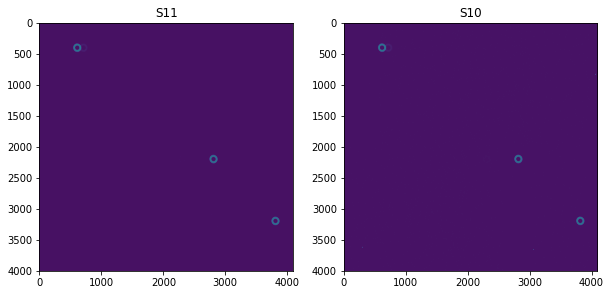

In [64]:
# 
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot=isrDir.name
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
postISRbutler = dafPersist.Butler(repoRoot, )
ccd_image = {}
for sensor in ['S11','S10']:
    dataId = dict(run='9006001', visit=4021123106001, raftName='R22', detectorName=sensor)
    exposure = postISRbutler.get('postISRCCD', **dataId) 
    image = exposure.image.array
    ccd_image[sensor]=image
    
fig,ax = plt.subplots(1,2,figsize=(10,5))

i = 0 
for sensor in ccd_image.keys():
    ax[i].imshow(ccd_image[sensor],vmax=800)
    ax[i].set_title(sensor)
    i += 1 

These look good, so lets continue : 

In [65]:
#def step4_setButlerInputsPath(self):
inputs = os.path.join(isrDir.name, "rerun", "run1")
wepCntlr.setPostIsrCcdInputs(inputs)


#    def step5_getTargetStar(self):

# Set the observation meta data
ra = 0.0
dec = 0.0
rotSkyPos = 0.0
wepCntlr.getSourSelc().setObsMetaData(ra, dec, rotSkyPos)

# Set the filter
wepCntlr.getSourSelc().setFilter(_filter)

# Get the target star by file
skyFilePath = os.path.join(modulePath, "tests","testData","phosimOutput","realComCam","skyComCamInfo.txt",)

(neighborStarMap,starMap,wavefrontSensors) = wepCntlr.getSourSelc().getTargetStarByFile(skyFilePath, offset=0)


# Do the assertion
#self.assertEqual(len(neighborStarMap), 2)
#self.assertEqual(len(starMap), 2)
#self.assertEqual(len(wavefrontSensors), 2)

In [66]:
#def step6_getPostIsrDefocalImgMap(self):

sensorNameList = list(wavefrontSensors)

intraObsId = 9006002
extraObsId = 9006001
obsIdList = [intraObsId, extraObsId]

wfsImgMap = wepCntlr.getPostIsrImgMapByPistonDefocal(sensorNameList, obsIdList)

# Assign the data for the following steps to use
#wfsImgMap = wfsImgMap

# Do the assertion
#assertEqual(len(wfsImgMap), 2)ame


In [67]:
def _getZkInNmFromOpd( opdId,opdDir):

    # Get the OPD data
    opdFileName = "opd_9006000_%d.fits.gz" % opdId
    opdFitsFile = os.path.join(opdDir, opdFileName)
    opd = fits.getdata(opdFitsFile)

    # Get x-, y-coordinate in the OPD image
    opdSize = opd.shape[0]
    opdGrid1d = np.linspace(-1, 1, opdSize)
    opdx, opdy = np.meshgrid(opdGrid1d, opdGrid1d)

    # Fit the OPD map with Zk
    idx = opd != 0
    znTerms = 22
    obscuration = 0.61
    zk = ZernikeAnnularFit(opd[idx], opdx[idx], opdy[idx], znTerms, obscuration)

    # Return the unit in nm (the unit in OPD is um)
    return zk * 1e3

In [68]:
# Compare with OPD
donutList = []
donutList.extend(donutMap["R22_S11"])
donutList.extend(donutMap["R22_S10"])

for aId in range(4):
    wfErr = donutList[aId].getWfErr()
    zkOfOpd = _getZkInNmFromOpd(aId,opdDir)[3:]
    delta = np.abs(wfErr[7] - zkOfOpd[7])
    print(delta)
    #self.assertLess(delta, 5)

KeyError: 'R22_S11'

In [ ]:
fig,ax  = plt.subplots(1,2,figsize=(12,4))
j = 0 
for sensor in donutMap.keys():
    for i in range(2):
        donut = donutMap[sensor][i]
        wfErr = donut.getWfErr()
        print(wfErr.argmax(), wfErr.max())
        aId = j
        print(sensor,aId)
        zkOfOpd = _getZkInNmFromOpd(aId,opdDir)[3:]
        ax[j].plot(wfErr-zkOfOpd,'-o')#marker='c')

    ax[j].set_title(sensor)
    ax[j].set_ylabel('wfErr')
    ax[j].set_xlabel('Zernike')
    j += 1 
 

In [ ]:
#def step8b_calcAvgWfErrOnSglCcd(self):

avgErrMap = dict()
for sensor, donutList in donutMap.items():
    avgErr = wepCntlr.calcAvgWfErrOnSglCcd(donutList)
    avgErrMap[sensor] = avgErr
    print(avgErr)
    print(avgErr.argmax(), avgErr.max())
    # Do the assertion
    #self.assertEqual(avgErr.argmax(), 2)
    #self.assertGreater(avgErr.max(), 100)



In [ ]:
# Compare with the central OPD
wfErrOnR22S11 = avgErrMap["R22_S11"]
zkOfOpdOnR22S11 = _getZkInNmFromOpd(4,opdDir)[3:]
deltaOnR22S11 = np.abs(wfErrOnR22S11[7] - zkOfOpdOnR22S11[7])
print(deltaOnR22S11)
#self.assertLess(deltaOnR22S11, 5)

wfErrOnR22S10 = avgErrMap["R22_S10"]
zkOfOpdOnR22S10 = _getZkInNmFromOpd(5,opdDir)[3:]
deltaOnR22S10 = np.abs(wfErrOnR22S10[7] - zkOfOpdOnR22S10[7])
print(deltaOnR22S10)
#self.assertLess(deltaOnR22S10, 5)


#def step9a_genMasterDonut(self):

masterDonutMap = wepCntlr.genMasterDonut(donutMap, zcCol=np.zeros(22))

# Do the assertion
print(len(masterDonutMap))
#self.assertEqual(len(self.masterDonutMap), 2)

for sensor, masterDonutList in masterDonutMap.items():
    #self.assertEqual(len(masterDonutList), 1)
    print(len(masterDonutList))

#def step9b_calcWfErrOfMasterDonut(self):

masterDonutMap = wepCntlr.calcWfErr(masterDonutMap)

masterDonutList = masterDonutMap["R22_S11"]
wfErr = masterDonutList[0].getWfErr()

# Do the assertion
print(wfErr.argmax(), wfErr.max())
#self.assertEqual(wfErr.argmax(), 2)
#self.assertGreater(wfErr.max(), 100)

# Compare with the central OPD
zkOfOpdOnR22S11 = _getZkInNmFromOpd(4,opdDir)[3:]
deltaOnR22S11 = np.abs(wfErr[7] - zkOfOpdOnR22S11[7])
#self.assertLess(deltaOnR22S11, 30)
print(deltaOnR22S11)

# `test_wepControllerMonolithicEimg_NEW.py` <a id='wepControllerMonolithicEimg'></a>

Run the loop to use ts_wep stars and make e-images...

    python bin.src/imgCloseLoop.py --inst comcam --numOfProc 25 --boresightDeg 0.0  0.0 --skyFile /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/skyComCamInfo.txt --output /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wepEimg --eimage
    
    cp /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wepEimg/iter0/img/extra/MC_H_20211231_006001_R22_S1* /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/extra/
    
    cp /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wepEimg/iter0/img/intra/MC_H_20211231_006002_R22_S1* /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/
    
    
    
    
    

In [3]:

import os
import numpy as np
import tempfile
from astropy.io import fits
import unittest

from lsst.ts.wep.bsc.BaseBscTestCase import BaseBscTestCase
from lsst.ts.wep.cwfs.Tool import ZernikeAnnularFit
from lsst.ts.wep.CamDataCollector import CamDataCollector
from lsst.ts.wep.SourceProcessor import SourceProcessor
from lsst.ts.wep.SourceSelector import SourceSelector
from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.WepController import WepController

from lsst.ts.wep.Utility import (
    getModulePath,
    FilterType,
    CamType,
    BscDbType,
    getConfigDir,
    getAmpImagesFromDir
)

'/project/scichris/aos/ts_wep/tests/tmp9ms69dsf/bsc.db3'

In [4]:
import os
import shutil
import tempfile

#createBscTest() 
"""Create the bright star catalog (BSC) used in the test."""
# Create a temporary test directory
testDir = os.path.join(getModulePath(), "tests")
_tempDir = tempfile.TemporaryDirectory(dir=testDir)

# Copy the db3 database
dbAdressSrc = os.path.join(testDir, "testData", "bsc.db3")
_dbAdress = os.path.join(_tempDir.name, "bsc.db3")
        
shutil.copy(dbAdressSrc,_dbAdress)


modulePath = getModulePath()

testDir = os.path.join(modulePath, "tests")
dataDir = tempfile.TemporaryDirectory(dir=testDir)
butlerInput = tempfile.TemporaryDirectory(dir=dataDir.name)
opdDir = os.path.join(
    modulePath, "tests", "testData", "opdOutput", "9006000"
)

# Configurate the WEP components
dataCollector = CamDataCollector(butlerInput.name)

def _configSourceSelector(_dbAdress):

    sourSelc = SourceSelector(CamType.ComCam, BscDbType.LocalDbForStarFile)

    # Set the criteria of neighboring stars
    starRadiusInPixel = 63
    spacingCoefficient = 2.5
    maxNeighboringStar = 1
    sourSelc.configNbrCriteria(
        starRadiusInPixel, spacingCoefficient, maxNeighboringStar=maxNeighboringStar
    )

    # Connect the database
    sourSelc.connect(_dbAdress)

    return sourSelc

sourSelc = _configSourceSelector(_dbAdress)
sourProc = SourceProcessor()

def _configWfEstimator():

    cwfsConfigDir = os.path.join(getConfigDir(), "cwfs")
    instDir = os.path.join(cwfsConfigDir, "instData")
    algoDir = os.path.join(cwfsConfigDir, "algo")
    wfEsti = WfEstimator(instDir, algoDir)

    # Use the comcam to calculate the LSST central raft image
    # with 1.5 mm defocal distance
    wfEsti.config(
        solver="exp",
        camType=CamType.ComCam,
        opticalModel="offAxis",
        defocalDisInMm=1.5,
        sizeInPix=160,
        debugLevel=0,
    )

    return wfEsti

wfEsti = _configWfEstimator()

# Instantiate the WEP controller
wepCntlr = WepController(dataCollector, None, sourSelc, sourProc, wfEsti)

# Intemediate data used in the test
_filter = FilterType.REF

neighborStarMap = dict()
starMap = dict()
wavefrontSensors = dict()

wfsImgMap = dict()
donutMap = dict()
masterDonutMap = dict()

In [5]:
#def step1_ingestEimg(self):

# Generate the PhoSim mapper
wepCntlr.getDataCollector().genLsstCamMapper()

intraImgFiles = os.path.join(
    getModulePath(),
    "tests",
    "testData",
    "phosimOutput",
    "realComCam",
    "repackagedFiles",
    "intra",
    "*_e.fits*",
)
extraImgFiles = os.path.join(
    getModulePath(),
    "tests",
    "testData",
    "phosimOutput",
    "realComCam",
    "repackagedFiles",
    "extra",
    "*_e.fits*",
)

wepCntlr.getDataCollector().ingestEimages(intraImgFiles)
wepCntlr.getDataCollector().ingestEimages(extraImgFiles)

In [6]:
#def step2_setButlerInputsPath(self):
wepCntlr.setPostIsrCcdInputs(butlerInput.name)


Look at the images to see that they look correctly ... 

In [8]:
os.listdir(butlerInput.name)

['_mapper', 'registry.sqlite3', 'eimage']

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot = butlerInput.name
butler = dafPersist.Butler(dataRoot, )

ccd_image = {}
for sensor in ['S11','S10']: 
    dataId = dict(run='9006002', raftName='R22', detectorName=sensor)
    post = butler.get('eimage', dataId)
    ccd_image[sensor]  = post.image.array


In [22]:
#plt.hist(np.ravel(ccd_image['S11']),range=(0,10))

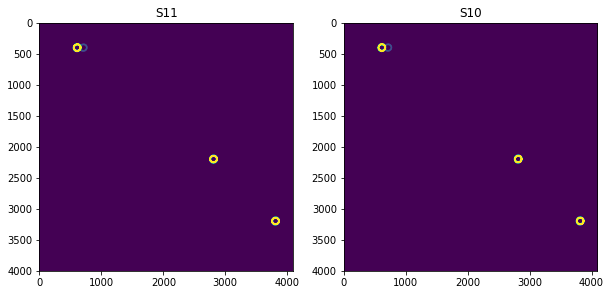

In [24]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

i = 0 
for sensor in ccd_image.keys():
    ax[i].imshow(ccd_image[sensor],vmin=2,vmax=100)
    ax[i].set_title(sensor)
    i += 1 

In [27]:
#def step3_getTargetStar(self):

# Set the observation meta data
ra = 0.0
dec = 0.0
rotSkyPos = 0.0
wepCntlr.getSourSelc().setObsMetaData(ra, dec, rotSkyPos)

# Set the filter
wepCntlr.getSourSelc().setFilter(_filter)

# Get the target star by file
skyFilePath = os.path.join(
    modulePath,
    "tests",
    "testData",
    "phosimOutput",
    "realComCam",
    "skyComCamInfo.txt",
)
(
    neighborStarMap,
    starMap,
    wavefrontSensors,
) = wepCntlr.getSourSelc().getTargetStarByFile(skyFilePath, offset=0)

# Assign the data for the following steps to use
neighborStarMap = neighborStarMap
starMap = starMap
wavefrontSensors = wavefrontSensors
print(len(neighborStarMap))
print(len(starMap))
print(len(wavefrontSensors))
# Do the assertion
# self.assertEqual(len(neighborStarMap), 2)
# self.assertEqual(len(starMap), 2)
# self.assertEqual(len(wavefrontSensors), 2)

2
2
2


In [28]:
#def step4_getEimgDefocalImgMap(self):

sensorNameList = list(wavefrontSensors)

intraObsId = 9006002
extraObsId = 9006001
obsIdList = [intraObsId, extraObsId]

wfsImgMap = wepCntlr.getEimgMapByPistonDefocal(sensorNameList, obsIdList)

# Assign the data for the following steps to use
#wfsImgMap = wfsImgMap

# Do the assertion
print(len(wfsImgMap))
#self.assertEqual(len(wfsImgMap), 2)

2


In [30]:
#def step5_getDonutMap(self):

donutMap = wepCntlr.getDonutMap(
    neighborStarMap, wfsImgMap, _filter, doDeblending=False
)

# Do the assertion
for sensor, donutList in donutMap.items():
    print(len(donutList))
    #assertEqual(len(donutList), 2)

2
2


In [31]:
#def step6a_calcWfErr(self):

donutMap = wepCntlr.calcWfErr(donutMap)

# Do the assertion
for sensor, donutList in donutMap.items():
    for donut in donutList:
        wfErr = donut.getWfErr()
        print(wfErr.argmax(), '  ', wfErr.max())
        
       # self.assertEqual(wfErr.argmax(), 2)
       # self.assertGreater(wfErr.max(), 100)



2    914.291713910765
2    915.2873760839487
1    912.4567116726422
1    897.4405495574059


NameError: name 'self' is not defined

In [32]:
def _getZkInNmFromOpd( opdId,opdDir):

    # Get the OPD data
    opdFileName = "opd_9006000_%d.fits.gz" % opdId
    opdFitsFile = os.path.join(opdDir, opdFileName)
    opd = fits.getdata(opdFitsFile)

    # Get x-, y-coordinate in the OPD image
    opdSize = opd.shape[0]
    opdGrid1d = np.linspace(-1, 1, opdSize)
    opdx, opdy = np.meshgrid(opdGrid1d, opdGrid1d)

    # Fit the OPD map with Zk
    idx = opd != 0
    znTerms = 22
    obscuration = 0.61
    zk = ZernikeAnnularFit(opd[idx], opdx[idx], opdy[idx], znTerms, obscuration)

    # Return the unit in nm (the unit in OPD is um)
    return zk * 1e3


# Compare with OPD
donutList = []
donutList.extend(donutMap["R22_S11"])
donutList.extend(donutMap["R22_S10"])

for aId in range(4):
    wfErr = donutList[aId].getWfErr()
    zkOfOpd = _getZkInNmFromOpd(aId, opdDir)[3:]
    delta = np.abs(wfErr[7] - zkOfOpd[7])
    print(delta)
    #self.assertLess(delta, 5)

5.8059275075638865
7.5571960295186855
7.415587583051007
5.931607094966061


In [33]:
#def step6b_calcAvgWfErrOnSglCcd(self):

avgErrMap = dict()
for sensor, donutList in donutMap.items():
    avgErr = wepCntlr.calcAvgWfErrOnSglCcd(donutList)
    avgErrMap[sensor] = avgErr

    # Do the assertion
    print(avgErr.argmax(), avgErr.max())
    #self.assertEqual(avgErr.argmax(), 2)
    #self.assertGreater(avgErr.max(), 100)

# Compare with the central OPD
wfErrOnR22S11 = avgErrMap["R22_S11"]
zkOfOpdOnR22S11 = _getZkInNmFromOpd(4,opdDir)[3:]
deltaOnR22S11 = np.abs(wfErrOnR22S11[7] - zkOfOpdOnR22S11[7])
print(deltaOnR22S11)
#self.assertLess(deltaOnR22S11, 5)

wfErrOnR22S10 = avgErrMap["R22_S10"]
zkOfOpdOnR22S10 = _getZkInNmFromOpd(5,opdDir)[3:]
deltaOnR22S10 = np.abs(wfErrOnR22S10[7] - zkOfOpdOnR22S10[7])
print(deltaOnR22S10)
#self.assertLess(deltaOnR22S10, 5)

2 914.7895449973569
1 904.9486306150241
6.984187049336867
6.383743098453579


In [34]:
#def step7a_genMasterDonut(self):

masterDonutMap = wepCntlr.genMasterDonut(donutMap, zcCol=np.zeros(22))

# Do the assertion
#assertEqual(len(self.masterDonutMap), 2)
print(len(masterDonutMap))
for sensor, masterDonutList in masterDonutMap.items():
    print(len(masterDonutList))
    #self.assertEqual(len(masterDonutList), 1)

2
1
1


In [35]:
#def step7b_calcWfErrOfMasterDonut(self):

masterDonutMap = wepCntlr.calcWfErr(masterDonutMap)

masterDonutList = masterDonutMap["R22_S11"]
wfErr = masterDonutList[0].getWfErr()

# Do the assertion
print(wfErr.argmax())
print(wfErr.max())
#assertEqual(wfErr.argmax(), 2)
#self.assertGreater(wfErr.max(), 100)

# Compare with the central OPD
zkOfOpdOnR22S11 = _getZkInNmFromOpd(4,opdDir)[3:]
deltaOnR22S11 = np.abs(wfErr[7] - zkOfOpdOnR22S11[7])
print(deltaOnR22S11)
#self.assertLess(deltaOnR22S11, 30)

2
804.0430013531186
14.502795232072142


All done! 

# `test_wEPCalculation_NEW.py` <a id='wEPCalculation'></a>

In [24]:

import os
import unittest
import tempfile

from lsst.ts.wep.Utility import (
    getModulePath,
    CamType,
    FilterType,
    runProgram,
    ImageType,
    BscDbType,
)
from lsst.ts.wep.ParamReader import ParamReader

from lsst.ts.wep.ctrlIntf.WEPCalculation import WEPCalculation
from lsst.ts.wep.ctrlIntf.AstWcsSol import AstWcsSol
from lsst.ts.wep.ctrlIntf.RawExpData import RawExpData

In [ ]:
p

In [42]:
modulePath = getModulePath()

testDir = os.path.join(modulePath, "tests")
testDataDir = os.path.join(testDir, "testData")

dataDir = tempfile.TemporaryDirectory(dir=testDir)
isrDir = tempfile.TemporaryDirectory(dir=dataDir.name)

wepCalculation = WEPCalculation(
    AstWcsSol(), CamType.ComCam,isrDir.name
)

In [43]:
print(dataDir.name,) 
print(isrDir.name)

/project/scichris/aos/ts_wep/tests/tmpw_h92xj2
/project/scichris/aos/ts_wep/tests/tmpw_h92xj2/tmpsx_nm0g4


In [44]:
skyFile = "test.txt"
wepCalculation.setSkyFile(skyFile)

filterType = FilterType.R
wepCalculation.setFilter(filterType)

In [45]:
#def testCalculateWavefrontErrors(self):

fakeFlatDir = tempfile.TemporaryDirectory(dir=dataDir.name)

def _genFakeFlat( fakeFlatDir, detector):

    currWorkDir = os.getcwd()
    os.chdir(fakeFlatDir)

    command = "makeGainImages.py"
    argstring = "--detector_list %s" % detector
    runProgram(command, argstring=argstring)

    os.chdir(currWorkDir)
    
    
def _genFlatCalibs( flatCalibsDir):

    detector = "R22_S11 R22_S10"
    _genFakeFlat(flatCalibsDir, detector)
    
    
def _genCalibsAndIngest( flatCalibsDir):

    _genFlatCalibs(flatCalibsDir)
    wepCalculation.ingestCalibs(flatCalibsDir)

        
_genCalibsAndIngest(fakeFlatDir.name)



In [21]:
#rawExpData??

In [46]:
#def _calculateWavefrontErrorsAndCheck(self):

comcamDataDir = os.path.join(testDataDir, "phosimOutput", "realComCam")

#def _prepareRawExpData(comcamDataDir):

intraImgDir = os.path.join(comcamDataDir, "repackagedFiles", "intra")
extraImgDir = os.path.join(comcamDataDir, "repackagedFiles", "extra")

rawExpData = RawExpData()

rawExpData.append(9006002, 0, intraImgDir)

extraRawExpData = RawExpData()
extraRawExpData.append(9006001, 0, extraImgDir)

listOfWfErr = wepCalculation.calculateWavefrontErrors(
        rawExpData, extraRawExpData=extraRawExpData
    )
print(len(listOfWfErr))
print(listOfWfErr[0].getSensorId(), listOfWfErr[1].getSensorId())


for sensorWavefrontData in listOfWfErr:
    sensorId = sensorWavefrontData.getSensorId()
    print(sensorId)
    #self.assertTrue(sensorId in (99, 100))

    listOfDonut = sensorWavefrontData.getListOfDonut()
    print(len(listOfDonut))
    #self.assertTrue(len(listOfDonut), 2)

    avgWfErr = sensorWavefrontData.getAnnularZernikePoly()
    print(avgWfErr.argmax(), avgWfErr.max())
    #self.assertEqual(avgWfErr.argmax(), 2)
    #self.assertGreater(avgWfErr.max(), 0.1)

/project/scichris/aos/ts_wep/python/lsst/ts/wep/ctrlIntf/WEPCalculation.py:588: UserWarning: No sky file assigned. Use the default one.
  warnings.warn(


2
100 99
100
2
2 0.9126134243745153
99
2
1 0.9025603109537635


/project/scichris/aos/ts_wep/python/lsst/ts/wep/ctrlIntf/WEPCalculation.py:588: UserWarning: No sky file assigned. Use the default one.
  warnings.warn(


2


100 99


100
2
2 0.9126134243745153
99
2
1 0.9025603109537635


In [47]:
# def testCalculateWavefrontErrorsOfEimg 
settingFile = wepCalculation.getSettingFile()
settingFile.updateSetting("imageType", "eimage")

In [48]:
comcamDataDir = os.path.join(testDataDir, "phosimOutput", "realComCam")

def _prepareRawExpData( comcamDataDir):

    intraImgDir = os.path.join(comcamDataDir, "repackagedFiles", "intra")
    extraImgDir = os.path.join(comcamDataDir, "repackagedFiles", "extra")

    rawExpData = RawExpData()
    rawExpData.append(9006002, 0, intraImgDir)

    extraRawExpData = RawExpData()
    extraRawExpData.append(9006001, 0, extraImgDir)

    return rawExpData, extraRawExpData
    
    
rawExpData, extraRawExpData = _prepareRawExpData(comcamDataDir)


In [74]:
rawExpData.getRawExpDir()

['/project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra']

In [52]:
from lsst.ts.wep.Utility import   getAmpImagesFromDir


In [54]:
intraImgDir

'/project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra'

In [60]:
rawExpDir  = intraImgDir
ampFiles = getAmpImagesFromDir(intraImgDir)
rawImgFiles = " "
for ampFile in ampFiles:
    rawImgFiles += ' %s'%os.path.join(rawExpDir, ampFile)

In [62]:
rawImgFiles.split()

['/project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/MC_H_20211231_006002_R22_S10.fits',
 '/project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/MC_H_20211231_006002_R22_S11.fits']

In [49]:
listOfWfErr = wepCalculation.calculateWavefrontErrors(
                rawExpData, extraRawExpData=extraRawExpData
            )

RuntimeError: Error running: ingestImages.py /project/scichris/aos/ts_wep/tests/tmpw_h92xj2/tmpsx_nm0g4 /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/*_e.fits* --configfile /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_lsst/21.0.0-20-g3c714e7+7952646d88/config/lsstCam/ingestEimg.py

First, ingest raw amp files : 

    ingestImages.py /project/scichris/aos/ts_wep/tests/tmpw_h92xj2/tmpsx_nm0g4 /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/MC_H_20211231_006002_R22_S10.fits /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/MC_H_20211231_006002_R22_S11.fits

In [51]:
... (do ISR, etc  - shouldn't affect anything )

'/project/scichris/aos/ts_wep/tests/tmpw_h92xj2/tmpsx_nm0g4'

Then, ingest  e-image files ...
    
    ingestImages.py /project/scichris/aos/ts_wep/tests/tmpw_h92xj2/tmpsx_nm0g4 /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/*_e.fits* --configfile /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_lsst/21.0.0-20-g3c714e7+7952646d88/config/lsstCam/ingestEimg.py

I didn't see that before, because I was testing raw / e-image ingestion separately (we don't run AOS both with raw amp and e-images at the same time ... ). But there wasn't such problem earlier as I recall.. Now the problem is 


       ingest.register INFO: Table "raw" exists.  Skipping creation
    ingest WARN: /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/MC_H_20211231_006002_R22_S10_e.fits: already ingested: {'seqNum': 6002, 'testType': 'PHOSIM', 'expTime': 15.0, 'object': 'UNKNOWN', 'imageType': 'SKYEXP', 'filter': 'g', 'lsstSerial': 'E2V-CCD250-356', 'date': '2021-12-31T23:59:52.500', 'dateObs': '2021-12-31T23:59:52.500', 'run': '9006002', 'visit': 4021123106002, 'wavelength': -666, 'raftName': 'R22', 'detectorName': 'S10', 'detector': 93, 'snap': 0, 'controller': 'H', 'obsid': 'MC_H_20211231_006002', 'expGroup': '4021123106002', 'expId': 4021123106002, 'dayObs': '2021-12-31'}
    ingest INFO: /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/MC_H_20211231_006002_R22_S10_e.fits --<link>--> /project/scichris/aos/ts_wep/tests/tmpw_h92xj2/tmpsx_nm0g4/eimage/4021123106002/E000/R22/eimage_4021123106002_R22_S10_E000.fits.gz
    ingest WARN: Failed to ingest file /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/MC_H_20211231_006002_R22_S10_e.fits: Failed to register file /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/MC_H_20211231_006002_R22_S10_e.fits
    Traceback (most recent call last):
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/pipe_tasks/21.0.0-51-gd3b42663+de9f4996ec/python/lsst/pipe/tasks/ingest.py", line 611, in runFile
        self.register.addRow(registry, info, dryrun=args.dryrun, create=args.create)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/pipe_tasks/21.0.0-51-gd3b42663+de9f4996ec/python/lsst/pipe/tasks/ingest.py", line 379, in addRow
        conn.cursor().execute(sql, values)
    sqlite3.IntegrityError: UNIQUE constraint failed: raw.expId, raw.detector, raw.visit


In [63]:
# check that these assertions are indeed true ... perhaps need to edit expId or visit ? 

# But really we won't do amp images AS WELL AS e-images at the same time .., It's either-or...

from astropy.io import fits
amp = fits.open(rawImgFiles.split()[0])

In [ ]:
 if intraSuffix in expId:  intraExpId = expId

In [66]:
expId is 4021123106002
detector is 93
visit is 4021123106002


In [104]:
amp[0].header['OBSID']

'MC_H_20211231_006002'

In [106]:
amp[0].header['RUNNUM']

'9006002'

In [107]:
amp[0].header['SEQNUM']+2000

8002

In [78]:
amp[0].header['EXP']

SyntaxError: invalid syntax (<ipython-input-78-6b8a6b9c5e02>, line 1)

In [67]:
amp[0].header['OBSID']

'MC_H_20211231_006002'

In [68]:
amp[0].header['SEQNUM']

6002

In [ ]:
For  reading the images with butler Gen2 , 
we use eg. 

visit = 9006002
raft = 'R00'
sensor = 'S11'
dataId = dict(run=str(visit), raftName=raft, detectorName=sensor)

and then we do 

butler.get("raw"..)

or 

butler.get("eimage").




In [88]:
isrDir.name

'/project/scichris/aos/ts_wep/tests/tmpc09xcdzq/tmps9gd_9iv'

In [114]:
import lsst.daf.persistence as dafPersist

butler = dafPersist.Butler(isrDir.name, )
sensor = 'S10'
dataId = dict(run='9006002', raftName='R22', detectorName=sensor)
post = butler.get("raw", dataId=dataId)



NoResults: No locations for get: datasetType:raw_amp dataId:DataId(initialdata={'run': '9006002', 'raftName': 'R22', 'detectorName': 'S10', 'dayObs': '2021-12-31', 'expId': 4021123108002, 'detector': 93, 'channel': 1}, tag=set())

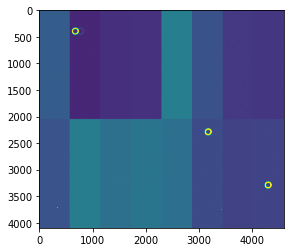

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(post.image.array,vmax=1200)

In [90]:
postE = butler.get("eimage", dataId=dataId)

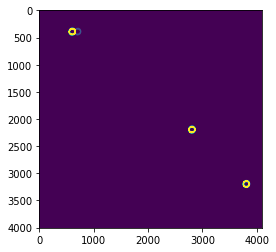

In [102]:
plt.imshow(postE.image.array,vmax=100)

In [ ]:
# The problem is that expId and visit are calculated based on `OBSID` , and with the same data and SEQNUM,
# which is coming from 9006002. ... 

# Perhaps in test_wEPCalculation.py  just need to clear the butler repo...

# I don't know why I have not seen this problem before -  perhaps I used different CCDs

# to test e-image ingestion? 



In [121]:
import os
import tempfile
import unittest

from lsst.ts.wep.CamDataCollector import CamDataCollector
from lsst.ts.wep.Utility import getModulePath, runProgram

testDir = os.path.join(getModulePath(), "tests")
dataDir = tempfile.TemporaryDirectory(dir=testDir)
isrDir = tempfile.TemporaryDirectory(dir=dataDir.name)
print(dataDir.name)
print(isrDir.name)

camDataCollector = CamDataCollector(isrDir.name)

/project/scichris/aos/ts_wep/tests/tmp2o9_v_5a
/project/scichris/aos/ts_wep/tests/tmp2o9_v_5a/tmpd08nk525


In [122]:
# ingest raw image 

camDataCollector.genLsstCamMapper()
mapperFilePath = os.path.join(isrDir.name, "_mapper")


imgFiles = os.path.join(
    getModulePath(),
    "tests",
    "testData",
    "phosimOutput",
    "realComCam",
    "repackagedFiles",
    "intra",
    "MC_H_20211231_006002_R22_S10.fits",
)
camDataCollector.ingestImages(imgFiles)

In [123]:
# ingest e-image 
imgFiles = os.path.join(
            getModulePath(),
            "tests",
            "testData",
            "phosimOutput",
            "realComCam",
            "repackagedFiles",
            "intra",
            "MC_H_20211231_008002_R22_S10_e.fits",
        )
camDataCollector.ingestEimages(imgFiles)
    

In [129]:
isrDir.name

'/project/scichris/aos/ts_wep/tests/tmp2o9_v_5a/tmpd08nk525'

In [136]:
# and show that I can get them by the usual dataId: 

import lsst.daf.persistence as dafPersist

butler = dafPersist.Butler(isrDir.name, )
dataId = dict(run='9006002', visit='4021123106002', raftName='R22', detectorName='S10')
post = butler.get("raw", dataId=dataId)


**The problem now is that if we have BOTH raw and e-image , we can't distinguish them by merely  "run",  "raftName", "detectorName", bacause these are the same ...**


How is it possible that there wasn't a problem with that when using the old phosim ingestEimg.py   retarget ?  Should I spend time on that?  

In the AOS loop we don't ingest amp images and e=images at the same tiem .... 


Make it so that the tests don;t fail, because I don't think it's worth wasting time on passing on the "visit" throughout `ts_wep` just to make it possible to ingest amp and e-images at the same time ... 




In [135]:
butler.queryMetadata('eimage', ['dayObs', 'visit', 'run', 'raftName', 'detectorName'], dataId, )

[('2021-12-31', 4021123106002, '9006002', 'R22', 'S10'),
 ('2021-12-31', 4021123108002, '9006002', 'R22', 'S10')]

[('2021-12-31', 4021123106002), ('2021-12-31', 4021123108002)]

In [ ]:
dataId = dict(run='9006002', raftName='R22', detectorName=sensor)

Given that, I made a small change to `phosim_repackager.py` , to ensure that for the same visit, run, etc. , the seqnum,  and hence expId or "visit", will be different:  

     sensor.header['SEQNUM'] = SEQNUM+2000  # ensuring uniqueness from amp image

And I run again the imgCloseLoop   to create e-images using ts_wep star catalog , but repackage them in a slightly different way ...  


python bin.src/imgCloseLoop.py --inst comcam --numOfProc 25 --boresightDeg 0.0  0.0 --skyFile /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/skyComCamInfo.txt --output /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wepEimg2 --eimage


And I copy them again... 


cp /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wepEimg2/iter0/img/extra/*_e.fits /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/extra/

cp /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wepEimg2/iter0/img/intra/*_e.fits /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/




# `test_camIsrWrapper_NEW` <a id='camIsrWrapper'></a>

In [142]:
import os
import tempfile
import unittest

from lsst.ts.wep.CamIsrWrapper import CamIsrWrapper
from lsst.ts.wep.CamDataCollector import CamDataCollector
from lsst.ts.wep.Utility import getModulePath, runProgram


testDir = os.path.join(getModulePath(), "tests")
dataDir = tempfile.TemporaryDirectory(dir=testDir)
isrDir = tempfile.TemporaryDirectory(dir=dataDir.name)

repackagedTestData = os.path.join(
    testDir,
    "testData",
    "phosimOutput",
    "realComCam",
    "repackagedFiles",
    "intra",
)

camIsrWrapper = CamIsrWrapper(isrDir.name)

# _getCamDataCollectorAndIngestCalibs 

# Generate the camera mapper
camDataCollector = CamDataCollector(isrDir.name)
camDataCollector.genLsstCamMapper()

# Generate the fake flat images
fakeFlatDir = tempfile.TemporaryDirectory(dir=dataDir.name)



def _changeWorkDir(dirPath):
    os.chdir(dirPath)

def _makeFakeFlat(detector):

    command = "makeGainImages.py"
    argstring = "--detector_list %s" % detector
    runProgram(command, argstring=argstring)
    
def _genFakeFlat(fakeFlatDir, detector):
    currWorkDir = os.getcwd()

    _changeWorkDir(fakeFlatDir)
    _makeFakeFlat(detector)
    _changeWorkDir(currWorkDir)

    
# Get the camDataCollector and ingest the calibs
detector = "R22_S11 R22_S10"

_genFakeFlat(fakeFlatDir.name, detector)

# Ingest the calibration images
calibFiles = os.path.join(fakeFlatDir.name, "*")
camDataCollector.ingestCalibs(calibFiles)



def _ingestRawAndDoIsr(imgFileName, camDataCollector, rerunName, doIsrConfig, repackagedTestData, camIsrWrapper, isrDir
):

    imgFiles = os.path.join(repackagedTestData, imgFileName)
    camDataCollector.ingestImages(imgFiles)

    # Do the ISR configuration
    if doIsrConfig is True:
        fileName = "isr_config.py"
        camIsrWrapper.config(doFlat=True, doOverscan=True, fileName=fileName)

    # Do the ISR
    camIsrWrapper.doISR(isrDir.name, rerunName=rerunName)

        
# Ingest the first raw images and do the ISR
imgFileName = "MC_H_20211231_006002_R22_S11.fits"
rerunName = "run1"
doIsrConfig=True
_ingestRawAndDoIsr(imgFileName, camDataCollector, rerunName, doIsrConfig,
                   repackagedTestData, camIsrWrapper, isrDir
 )

#def testDoIsrContinuous(self):



In [146]:
os.listdir(isrDir.name)

['isr_config.py',
 'calibRegistry.sqlite3',
 'raw',
 '_mapper',
 'flat',
 'registry.sqlite3',
 'rerun']

In [147]:
def _getNumOfDir( dirPath):

    numOfDir = sum(
        os.path.isdir(os.path.join(dirPath, aDir))
        for aDir in os.listdir(path=dirPath)
    )

    return numOfDir
    
postIsrCcdDir = os.path.join(isrDir.name, "rerun", rerunName, "postISRCCD")
numOfDir = _getNumOfDir(postIsrCcdDir)
print(numOfDir)

1


In [149]:
# Ingest the second raw image and do the ISR again
imgFileName = "MC_H_20211231_006002_R22_S10.fits"
doIsrConfig=False
_ingestRawAndDoIsr(imgFileName, camDataCollector, rerunName, doIsrConfig,
                    repackagedTestData, camIsrWrapper, isrDir )

In [153]:
postIsrCcdDir = os.path.join(isrDir.name, "rerun", rerunName, "postISRCCD",
            "4021123106002-g","R22")
len(os.listdir(postIsrCcdDir))

2

# `test_butlerWrapper_NEW` <a id='butlerWrapper'></a>

In [154]:
import os
import numpy as np
import tempfile
import unittest

from lsst.ts.wep.CamDataCollector import CamDataCollector
from lsst.ts.wep.ButlerWrapper import ButlerWrapper
from lsst.ts.wep.Utility import getModulePath


dataDirPath = os.path.join(getModulePath(), "tests")
dataDir = tempfile.TemporaryDirectory(dir=dataDirPath)

def _ingestImages(dataDir):

    # Generate the camera mapper
    camDataCollector = CamDataCollector(dataDir.name)
    camDataCollector.genLsstCamMapper()

    # Ingest the E image
    imgFilesEimg = os.path.join(
        getModulePath(),
        "tests",
        "testData",
        "phosimOutput",
        "realComCam",
        "repackagedFiles",
        "intra",
        "MC_H_20211231_006002_R22_S10_e.fits",
    )
    camDataCollector.ingestEimages(imgFilesEimg)

    # Ingest the amplifier image
    imgFilesRaw = os.path.join(
        getModulePath(),
        "tests",
        "testData",
        "phosimOutput",
        "realComCam",
        "repackagedFiles",
        "intra",
            "MC_H_20211231_006002_R22_S11.fits",
        )
    camDataCollector.ingestImages(imgFilesRaw)

_ingestImages(dataDir)

In [155]:
butlerWrapper = ButlerWrapper(dataDir.name)

In [156]:
def _getRawExp(butlerWrapper):
    visit = 9006002
    raft = "R22"
    sensor = "S11"
    return butlerWrapper.getRawExp(visit, raft, sensor)

#def testGetRawExp(self):
exposure = _getRawExp(butlerWrapper)

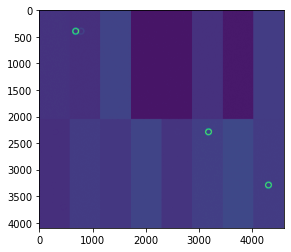

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(exposure.image.array)

In [165]:
def _getEimage(butlerWrapper):

    visit = 9006002
    raft = "R22"
    sensor = "S10"
    return butlerWrapper.getEimage(visit, raft, sensor)
exposure =_getEimage(butlerWrapper)

In [166]:
exposure.getDimensions().getX()

4096

In [167]:
exposure.getDimensions().getY()

4004

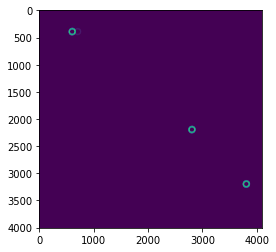

In [168]:
plt.imshow(exposure.image.array)

In [169]:
exposure = _getEimage(butlerWrapper)

In [170]:
image = ButlerWrapper.getImageData(exposure)

In [171]:
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [173]:
isinstance(image, np.ndarray)

True

In [174]:
image.shape

(4004, 4096)

# `test_sourceProcessor_NEW ` <a id='sourceProcessor'></a>

In [1]:
import os
import numpy as np
import unittest

from lsst.ts.wep.SourceProcessor import SourceProcessor
from lsst.ts.wep.bsc.NbrStar import NbrStar
from lsst.ts.wep.Utility import getModulePath, FilterType

In [3]:
modulePath = getModulePath()
sourProc = SourceProcessor()


In [3]:
sourProc.config(sensorName="R00_SW1")

In [4]:
sourProc.sensorName

'R00_SW1'

In [5]:
len(sourProc.sensorDimList)

205

In [4]:
wfsSensorName = "R44_SW0"
sourProc.getEulerZinDeg(wfsSensorName)

0.018799000000001342

Compare the reading of `focalplanelayout` file before and after the changes : 

In [7]:
from lsst.ts.wep.Utility import readPhoSimSettingData
folderPath = '/project/scichris/aos/ts_wep/policy/'
sensorEulerRotNew = readPhoSimSettingData(folderPath, 'focalplanelayout.txt', "eulerRot")

In [9]:
#sensorEulerRotNew

In [9]:
sensorEulerRotNew['R44_SW0']

['0.018799000000001342', '0.000000', '0.000000']

In [10]:
# needed to copy /data/lsst/focalplanelayout_old.txt to a different folder,
# because readPhoSimSettingData requires the file to be 
# named 'focalplanelayout.txt' or it throws an error 

folderPath = '/project/scichris/aos/phosim_old_data/'
sensorEulerRotOld = readPhoSimSettingData(folderPath, 'focalplanelayout.txt', "eulerRot")

In [7]:
#R40_S02_C0 --> R40_SW1 
#R40_S02_C1  --> R40_SW0 
sensorEulerRotOld['R40_S02_C1']

['90.004585', '0.000000', '0.000000']

Show values in `lsstCam` in `obs_lsst`:

In [1]:
from lsst.obs.lsst import LsstCam

import lsst.geom as geom
import lsst.afw.cameraGeom as cameraGeom


camera = LsstCam.getCamera()

for detector in camera:
    if ('SW' in detector.getName()) or ('SG' in detector.getName()):
        bbox = detector.getBBox()
        xp, yp = detector.getCenter(cameraGeom.FOCAL_PLANE)  # centre of CCD
        yaw = detector.getOrientation().getYaw().asDegrees()  # rotation in the plane of the camera  (also getPitch() and getRoll(); see afw/cameraGeom/Orientation.h)
        print(f"{detector.getName():10} ({xp:9.4f}, {yp:9.4f}) mm  {yaw} deg")

R00_SG0    (-212.2300, -258.7500) mm  450.0 deg
R00_SG1    (-258.7300, -212.2300) mm  180.0 deg
R00_SW0    (-214.2400, -202.6150) mm  180.0 deg
R00_SW1    (-214.2600, -225.8850) mm  360.0 deg
R04_SG0    ( 258.7500, -212.2300) mm  540.0 deg
R04_SG1    ( 212.2300, -258.7300) mm  270.0 deg
R04_SW0    ( 202.6150, -214.2400) mm  270.0 deg
R04_SW1    ( 225.8850, -214.2600) mm  450.0 deg
R40_SG0    (-258.7500,  212.2300) mm  360.0 deg
R40_SG1    (-212.2300,  258.7300) mm  90.0 deg
R40_SW0    (-202.6150,  214.2400) mm  90.0 deg
R40_SW1    (-225.8850,  214.2600) mm  270.0 deg
R44_SG0    ( 212.2300,  258.7500) mm  270.0 deg
R44_SG1    ( 258.7300,  212.2300) mm  0.0 deg
R44_SW0    ( 214.2400,  202.6150) mm  0.0 deg
R44_SW1    ( 214.2600,  225.8850) mm  180.0 deg


In the LsstCamPhosim mapper **none ** of the sensors has any rotation (!). Probably best to keep things unchanged, and apply any tweaks to the postISR images as needed. 

In [23]:
from lsst.obs.lsst import LsstCamPhoSim

import lsst.geom as geom
import lsst.afw.cameraGeom as cameraGeom


camera = LsstCamPhoSim.getCamera()

for detector in camera:
    #if ('SW' in detector.getName()) or ('SG' in detector.getName()):
    bbox = detector.getBBox()
    xp, yp = detector.getCenter(cameraGeom.FOCAL_PLANE)  # centre of CCD
    yaw = detector.getOrientation().getYaw().asDegrees()  # rotation in the plane of the camera  (also getPitch() and getRoll(); see afw/cameraGeom/Orientation.h)
    print(f"{detector.getName():10} ({xp:9.4f}, {yp:9.4f}) mm  {yaw} deg")#cameraGeom.Orientation??

R01_S00    (-169.9800, -296.0000) mm  0.0 deg
R01_S01    (-127.7000, -296.1300) mm  0.0 deg
R01_S02    ( -85.4300, -296.1800) mm  0.0 deg
R01_S10    (-169.9300, -253.7300) mm  0.0 deg
R01_S11    (-127.6100, -253.8100) mm  0.0 deg
R01_S12    ( -85.3300, -253.9100) mm  0.0 deg
R01_S20    (-169.8000, -211.4500) mm  0.0 deg
R01_S21    (-127.5100, -211.5300) mm  0.0 deg
R01_S22    ( -85.2500, -211.6100) mm  0.0 deg
R02_S00    ( -42.8800, -296.3000) mm  0.0 deg
R02_S01    (  -0.6000, -296.4300) mm  0.0 deg
R02_S02    (  41.6700, -296.4800) mm  0.0 deg
R02_S10    ( -42.8300, -254.0300) mm  0.0 deg
R02_S11    (  -0.5100, -254.1100) mm  0.0 deg
R02_S12    (  41.7700, -254.2100) mm  0.0 deg
R02_S20    ( -42.7000, -211.7500) mm  0.0 deg
R02_S21    (  -0.4100, -211.8300) mm  0.0 deg
R02_S22    (  41.8500, -211.9100) mm  0.0 deg
R03_S00    (  84.2200, -296.6000) mm  0.0 deg
R03_S01    ( 126.5000, -296.7300) mm  0.0 deg
R03_S02    ( 168.7700, -296.7800) mm  0.0 deg
R03_S10    (  84.2700, -254.3300) 

In [22]:
bbox

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(4072, 4000))

In [193]:
len(sourProc.sensorFocaPlaneInUm)

205

In [194]:
sourProc.sensorDimList["R00_SW1"]

(2000, 4072)

In [195]:
sourProc.sensorDimList["R22_S11"]

(4004, 4096)

In [196]:
sourProc.sensorFocaPlaneInDeg["R22_S11"]

(0.0, 0.0)

In [11]:
sourProc.sensorFocaPlaneInDeg["R00_SW0"]

(-1.1256388888888889, -1.1902222222222223)

In [12]:
sourProc.sensorFocaPlaneInDeg["R00_SW1"]

(-1.2549166666666667, -1.1903333333333332)

In [203]:
pixelX = 1000
pixelY = 2036
fieldX, fieldY = sourProc.camXYtoFieldXY(pixelX, pixelY)

In [204]:
fieldX

-1.2549166666666667

In [205]:
fieldY

-1.1903333333333332

In [207]:
sourProc = SourceProcessor()


(-1.2549166666666667, -1.1903333333333332)

In [26]:
from lsst.ts.wep.SourceProcessor import SourceProcessor
#import imp
#imp.reload(SourceProcessor)

sourProc = SourceProcessor()

def _camXYtoFieldXY(sensorName, pixelX, pixelY,sourProc):

    sourProc.config(sensorName=sensorName)
    fieldX, fieldY = sourProc.camXYtoFieldXY(pixelX, pixelY)

    return fieldX, fieldY

oxR00SW1, oyR00SW1 = _camXYtoFieldXY("R00_SW1", 0, 0, sourProc)
oxR00SW0, oyR00SW0 = _camXYtoFieldXY("R00_SW0", 0, 0, sourProc)
oxR40SW1, oyR40SW1 = _camXYtoFieldXY("R40_SW1", 0, 0, sourProc)
oxR40SW0, oyR40SW0 = _camXYtoFieldXY("R40_SW0", 0, 0, sourProc)
oxR44SW1, oyR44SW1 = _camXYtoFieldXY("R44_SW1", 0, 0, sourProc)
oxR44SW0, oyR44SW0 = _camXYtoFieldXY("R44_SW0", 0, 0, sourProc)
oxR04SW1, oyR04SW1 = _camXYtoFieldXY("R04_SW1", 0, 0, sourProc)
oxR04SW0, oyR04SW0 = _camXYtoFieldXY("R04_SW0", 0, 0, sourProc)

print(oxR00SW1, oyR00SW1)
print(oxR00SW0, oyR00SW0)


In [27]:
print(oxR00SW1,oyR00SW1)

-1.2549166666666667 -1.3034444444444444


In [28]:
print(oxR00SW0, oyR00SW0)

-1.0700833333333333 -1.0771111111111111


In [13]:
print(oxR40SW1, oyR40SW1)

1.3034444444444444 -1.2549166666666667


In [14]:
print(oxR40SW0, oyR40SW0)

1.0771111111111111 -1.1256388888888889


In [15]:
print(oxR44SW1, oyR44SW1)

1.3104722222222223 1.3034444444444444


In [16]:
print(oxR44SW0, oyR44SW0)

1.1256388888888889 1.0771111111111111


In [17]:
print(oxR04SW1, oyR04SW1)

-1.3034444444444444 1.2549166666666667


In [18]:
print(oxR04SW0, oyR04SW0)

-1.0771111111111111 1.1256388888888889


In [ ]:
def _camXYtoFieldXY(sensorName, pixelX, pixelY,sourProc):

    sourProc.config(sensorName=sensorName)
    fieldX, fieldY = sourProc.camXYtoFieldXY(pixelX, pixelY)

    return fieldX, fieldY

In [ ]:
a = 1.303444
b = 1.310472
c = 1.077111
d = 1.070083

oxR00SW0 = -d
oyR00SW0 = -c

oxR00SW1 = -b
oyR00SW1 = -a

oxR40SW0 = c
oyR40SW0 = -d 

oxR40SW1 = a
oyR40SW1 = -b

oxR44SW0 = d
oyR44SW0 = c

oxR44SW1 = b
oyR44SW1 = a

oxR04SW0 = -c
oyR04SW0 = d

oxR04SW1 = -a
oyR04SW1 = b

self.assertLess(abs(oxR00SW1 - oyR40SW1), 1e-3) -b,-b
self.assertLess(abs(oxR04SW0 - oyR00SW0), 1e-3)  -c, -c 
self.assertLess(abs(oxR40SW1 - oyR44SW1), 1e-3) a , a
self.assertLess(abs(oxR44SW0 - oyR04SW0), 1e-3) d,  d

    
    
self.assertEqual((oxR00SW1 + oyR04SW1, oyR40SW1 + oyR04SW1), (0, 0))  -b, b    -b, b
self.assertEqual((oyR00SW0 + oyR44SW0, oxR40SW0 + oxR04SW0), (0, 0))  -c, c    c, -c 

In [1]:
from lsst.ts.wep.SourceProcessor import SourceProcessor
sourProc = SourceProcessor()

In [ ]:
fieldXc, fieldYc = sourProc.sensorFocaPlaneInDeg[sourProc.sensorName]

In [33]:
sensorName = 'R00_SW0'
sourProc.config(sensorName=sensorName)
fieldXum, fieldYum = sourProc.sensorFocaPlaneInUm[sourProc.sensorName]

In [35]:
R44_SW1 225885.0 214260.0
R44_SW0 202615.0 214240.0
R04_SW1 -214260.0 225885.0
R04_SW0 -214240.0 202615.0
R00_SW1 -225885.0 -214260.0
R00_SW0 -202615.0 -214240.0
R40_SW1 214260.0 -225885.0
R40_SW0 214240.0 -202615.0

-202615.0 -214240.0


In [29]:
sensorName = 'R44_SW0'
sourProc.config(sensorName=sensorName)
pixelX, pixelY = 0,0

#def camXYtoFieldXY( pixelX, pixelY):
"""Get the field X, Y from the pixel x, y position on CCD.

Parameters
----------
pixelX : float
    Pixel x on camera coordinate.
pixelY : float
    Pixel y on camera coordinate.

Returns
-------
float
    Field x in degree.
float
    Field y in degree.
"""

# The wavefront sensors will do the rotation as
# following, based on the Euler angle.

#    R04                 R44
# O-------           ----------O        /\ +y (CCS)
# |  SW1 |           |    |    |        |
# |------|           |SW0 | SW1|        |
# |  SW0 |           |    |    |        |
# -------O           O----------        _
#                                   +z (.) -----> +x
#      R00                  R40
# ------------O          O-------
# |     |     |          |  SW0 |
# | SW1 | SW0 |          |------|
# |     |     |          |  SW1 |
# O------------          -------O

# Get the field X, Y of sensor's center
fieldXc, fieldYc = sourProc.sensorFocaPlaneInDeg[sourProc.sensorName]

# Get the center pixel position
pixelXc, pixelYc = sourProc.sensorDimList[sourProc.sensorName]
pixelXc = pixelXc / 2
pixelYc = pixelYc / 2

# Calculate the delta x and y in degree
# 1 degree = 3600 arcsec
pixelToArcsec = sourProc.settingFile.getSetting("pixelToArcsec")
deltaX = (pixelX - pixelXc) * pixelToArcsec / 3600.0
deltaY = (pixelY - pixelYc) * pixelToArcsec / 3600.0

# Calculate the transformed coordinate in degree.
fieldX, fieldY = sourProc._rotCam2FocalPlane(
    sourProc.sensorName, fieldXc, fieldYc, deltaX, deltaY
)
print(fieldX, fieldY)
#return fieldX, fieldY

1.1256388888888889 1.0771111111111111


In [10]:
from lsst.ts.wep.Utility import (readPhoSimSettingData,getConfigDir)
focalPlaneFileName="focalplanelayout.txt"
configDir = getConfigDir()
folderPath=configDir
ccdData = readPhoSimSettingData(folderPath, focalPlaneFileName, "fieldCenter")

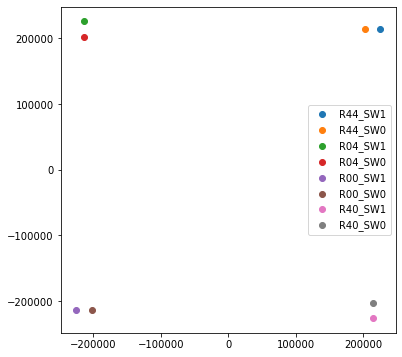

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(6,6))
for sensor in ['R44_SW1', 'R44_SW0',
              'R04_SW1', 'R04_SW0',
              'R00_SW1','R00_SW0',
              'R40_SW1', 'R40_SW0']:
    xInUm = float(ccdData[sensor][0])
    yInUm = float(ccdData[sensor][1])
    ax.scatter(xInUm,yInUm, label=sensor )
ax.legend()

In [21]:
ccdData[sensor][0]

'214240.0'

In [7]:


focalPlaneData = ccdData[sensorName]
xInUm = float(focalPlaneData[0])
yInUm = float(focalPlaneData[1])
pixelSizeInUm = float(focalPlaneData[2])
sizeXinPixel = float(focalPlaneData[3])
print(focalPlaneData)

# Consider the x-translation in corner wavefront sensors
tempX = None
tempY = None

if sensorName in ("R44_SW1", "R00_SW0"):
    # Shift center to +x direction
    tempX = xInUm + sizeXinPixel / 2 * pixelSizeInUm
elif sensorName in ("R44_SW0", "R00_SW1"):
    # Shift center to -x direction
    tempX = xInUm - sizeXinPixel / 2 * pixelSizeInUm
elif sensorName in ("R04_SW0", "R40_SW1"):
    # Shift center to -y direction
    tempY = yInUm - sizeXinPixel / 2 * pixelSizeInUm
elif sensorName in ("R04_SW1", "R40_SW0"):
    # Shift center to +y direction
    tempY = yInUm + sizeXinPixel / 2 * pixelSizeInUm

# Replace the value by the shifted one
if tempX is not None:
    focalPlaneData[0] = str(tempX)
elif tempY is not None:
    focalPlaneData[1] = str(tempY)

1.1902222222222223

In [17]:
focalPlaneData

['202615.0', '214240.0', '10.0', '2000', '4072']

In [ ]:
same:
    
    oxR00SW1  oyR40SW1   -1.3104722222222223
    oxR00SW0  oyR40SW0   -1.0700833333333333
    oxR40SW1  oyR44SW1   1.303444444444444 
    oxR40SW0   oyR44SW0  1.0771111111111111
    oyR00SW1   oxR04SW1  -1.3034444444444444
    oxR44SW1  oyR04SW1  1.3104722222222223
    oyR00SW0  oxR04SW0  -1.0771111111111111
    oxR44SW0  oyR04SW0  1.0700833333333333
    
opposites : their sum is 0   
    oxR00SW1 + oxR44SW1, oyR40SW1+oyR04SW1  -1.3104722222222223  + 1.3104722222222223
    oxR00SW0+oxR44SW0, oyR40SW0+oyR04SW0  -1.0700833333333333 +1.0700833333333333

In [14]:
print(oxR00SW1)

-1.3104722222222223


In [15]:
print(oyR00SW1)

-1.3034444444444444


In [16]:
print(oxR00SW0)

-1.0700833333333333


In [17]:
print(oyR00SW0)

-1.0771111111111111


In [18]:
print(oxR40SW1)

1.3034444444444444


In [19]:
print(oyR40SW1)

-1.3104722222222223


In [20]:
print(oxR40SW0)

1.0771111111111111


In [21]:
print(oyR40SW0)

-1.0700833333333333


In [23]:
print(oxR44SW1)

1.3104722222222223


In [25]:

print(oyR44SW1)

1.3034444444444444


In [26]:
print(oxR44SW0)

1.0700833333333333


In [27]:
print(oyR44SW0)

1.0771111111111111


In [28]:
print(oxR04SW1)

-1.3034444444444444


In [29]:
print(oyR04SW1)

1.3104722222222223


In [30]:
print(oxR04SW0)

-1.0771111111111111


In [31]:
print(oyR04SW0)

1.0700833333333333


In [22]:
print(oyR00SW1, oyR00SW0)
print(abs(oyR00SW1-oyR00SW0))

-1.3034444444444444 -1.0771111111111111
0.22633333333333328


In [222]:
0.000111111 < 1e-3

True

In [15]:
a = oyR00SW1
b = oyR00SW0
round(a-b, 7)

-0.0001111

In [16]:
print(oxR40SW1, oxR40SW0)
print(abs(oxR40SW1-oxR40SW0))

1.3034444444444444 1.3033333333333335
0.00011111111111095084


In [17]:
print(oyR44SW1, oyR44SW0)
print(abs(oyR44SW1-oyR44SW0))

1.3034444444444444 1.3033333333333335
0.00011111111111095084


In [18]:
print(oxR04SW1, oxR04SW0)
print(abs(oxR04SW1- oxR04SW0))

-1.3034444444444444 -1.3033333333333335
0.00011111111111095084


In [ ]:
I wonder why this offset is identical... 

In [19]:
print(oxR00SW1 + oxR44SW1) 

0.0


In [20]:
print(oyR00SW1 + oyR44SW1)

0.0


In [21]:
print(oxR40SW0 + oxR04SW0)
print(oyR40SW0 + oyR04SW0)

0.0
0.0


In [227]:
sourProc.config(sensorName="R22_S11")
sourProc.dmXY2CamXY(4070, 1000)

(1000, 4070)

In [228]:
sourProc.camXY2DmXY(3000, 4070)

(4070, 3000)

In [229]:
sourProc.isVignette(1.76, 0)

True

In [230]:
sourProc.isVignette(0.2, 0.2)

False

In [232]:
def _getFieldXyOfLsst():

    nArm = 6
    armLen = [0.379, 0.841, 1.237, 1.535, 1.708]
    fieldWFSx = [1.176, -1.176, -1.176, 1.176]
    fieldWFSy = [1.176, 1.176, -1.176, -1.176]
    pointAngle = np.arange(nArm) * (2 * np.pi) / nArm
    fieldX = np.concatenate(
        [np.zeros(1), np.kron(armLen, np.cos(pointAngle)), fieldWFSx]
    )
    fieldY = np.concatenate(
        [np.zeros(1), np.kron(armLen, np.sin(pointAngle)), fieldWFSy]
    )

    return np.array([fieldX, fieldY]).T

In [233]:
fieldXY = _getFieldXyOfLsst()
mapping = sourProc.mapSensorAndFieldIdx(fieldXY)

In [234]:
mapping["R22_S11"]

0

# `test_createPhosimDonutTemplates.py`




In [1]:
import unittest
import os
import shutil
import tempfile
import numpy as np

from lsst.ts.wep.CreatePhosimDonutTemplates import CreatePhosimDonutTemplates
from lsst.ts.wep.Utility import getConfigDir, getModulePath, DefocalType


In [14]:
createPhosimDonuts = CreatePhosimDonutTemplates()

modulePath = getModulePath()
testDataDir = os.path.join(modulePath, "tests", "testData")

# Location where phosim input files exist.
# Also where temp work directory is created.
templateDataDir = os.path.join(getConfigDir(), "cwfs", "donutTemplateData")

# Location where templates are created
templateDir = os.path.join(templateDataDir, "phosimTemplates")

# Temporary work directory : made inside "tests/"
testDir = os.path.join(modulePath, "tests")
tempTestDirectory = tempfile.TemporaryDirectory(dir=testDir)
tempWorkDir = tempTestDirectory.name
createPhosimDonuts.setTempWorkPaths(tempWorkDir)

In [15]:
print(testDataDir)
print(templateDataDir)
print(templateDir)
print(tempWorkDir)

/project/scichris/aos/ts_wep/tests/testData
/project/scichris/aos/ts_wep/policy/cwfs/donutTemplateData
/project/scichris/aos/ts_wep/policy/cwfs/donutTemplateData/phosimTemplates
/project/scichris/aos/ts_wep/tests/tmpll_i8jm2


In [17]:
#def testCreateAndCleanUpWorkDirectories(self):

# Test clean up of work directories
createPhosimDonuts.cleanUpWorkDirs()
print(os.path.exists(tempWorkDir)) # should be false

# Test creation of work directories
createPhosimDonuts.createWorkDirectories()

# both should be true 
print(os.path.exists(tempWorkDir))
print(os.path.exists(os.path.join(tempWorkDir, "phosimOutput", "extra"))
)

False
Making temporary work directories
True
True


In [18]:
#def testCreateDetectorLists(self):

testDetectors = "R22_S00 R22_S11"

detStrPhosim, detStrFlats = createPhosimDonuts.createDetectorLists(
    testDetectors
)
print(detStrPhosim)  # self.assertEqual(detStrPhosim, "R22_S00|R22_S11")
print(detStrFlats) # self.assertEqual(detStrFlats, "R22_S00 R22_S11")



R22_S00|R22_S11
R22_S00 R22_S11


In [23]:
def _copyPhosimFiles(testDataDir,tempWorkDir):
    source  = os.path.join(
                testDataDir,
                "phosimOutput","realComCam","repackagedFiles", "extra",
                "MC_H_20211231_006001_R22_S10.fits")
    destination =  os.path.join(
                tempWorkDir, "raw", "MC_H_20211231_006001_R22_S10.fits")

    shutil.copy(source, destination)
    print('cp %s %s'%(source,destination))

In [19]:
print(testDataDir)

/project/scichris/aos/ts_wep/tests/testData


In [20]:
print(tempWorkDir)

/project/scichris/aos/ts_wep/tests/tmpll_i8jm2


In [21]:
os.listdir(tempWorkDir)

['calibs', 'raw', 'phosimWorkDir', 'phosimOutput', 'input']

In [24]:
#def testIngestImages(self):
# Populate the raw phosim output directory
createPhosimDonuts.createWorkDirectories()
_copyPhosimFiles(testDataDir, tempWorkDir)
# Run the ingest
createPhosimDonuts.ingestImages()  # <-- needed to edit to use LsstCamMapper by default ... 

# check that the ingested file exists ... 


Making temporary work directories
cp /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/extra/MC_H_20211231_006001_R22_S10.fits /project/scichris/aos/ts_wep/tests/tmpll_i8jm2/raw/MC_H_20211231_006001_R22_S10.fits
Ingest images


RuntimeError: Error running: ingestImages.py /project/scichris/aos/ts_wep/tests/tmpll_i8jm2/input /project/scichris/aos/ts_wep/tests/tmpll_i8jm2/raw/*.fits

In [27]:
path_to_ingested_raws =  os.path.join(tempWorkDir,"input",
        "raw","2021-12-31","4021123106001","4021123106001-R22-S10-det093.fits" )
print(os.path.exists(path_to_ingested_raws))

True


In [28]:
#def testMakeFlatsAndIngest(self):

#createPhosimDonuts.createWorkDirectories()
# Populate the repo first
#_copyPhosimFiles()
#createPhosimDonuts.ingestImages()
# Make Flats and Ingest
createPhosimDonuts.makeFlats("R22_S10")
createPhosimDonuts.ingestCalibs()

print(
    os.path.exists(os.path.join(tempWorkDir, "input", "flat", "g"))
    )

Making flats
Ingest Flats
True


In [29]:
#def testRunISR(self):

#createPhosimDonuts.createWorkDirectories()
# Populate the repo
#_copyPhosimFiles()
#createPhosimDonuts.ingestImages()
# Add flats
#createPhosimDonuts.makeFlats("R22_S10")
#self.createPhosimDonuts.ingestCalibs()

# Run the ISR
createPhosimDonuts.runISR()


Running ISR


Show the postISRCCD to prove that ISR was correct : 

In [30]:
isrPath = os.path.join(
    "input", "rerun","run1","postISRCCD","4021123106001-g","R22",
)
print(
    os.path.exists(
        os.path.join(
            tempWorkDir,
            isrPath,
            "postISRCCD_4021123106001-g-R22-S10-det093.fits"
        )
    )
)

True


In [31]:
shutil.copy(
        os.path.join(
            testDataDir,
            "testDonutTemplates",
            "centroid_lsst_e_9006001_f1_R99_S11_E000.txt",
        ),
        os.path.join(tempWorkDir, "phosimOutput", "extra"),
    )

'/project/scichris/aos/ts_wep/tests/tmpll_i8jm2/phosimOutput/extra/centroid_lsst_e_9006001_f1_R99_S11_E000.txt'

In [33]:
#def testCutOutTemplatesAndSave(self):

testPhosimPath = os.path.join(testDataDir, "phosimOutput", "donutTemplates")

# Move centroid file into place
#createPhosimDonuts.createWorkDirectories()
#_copyPhosimFiles()

createPhosimDonuts.cutOutTemplatesAndSave(
    testPhosimPath, 240, DefocalType.Extra, 9006001,
)



In [34]:
os.list

'/project/scichris/aos/ts_wep/tests/testData/phosimOutput/donutTemplates'

In [36]:
newTemplate = np.genfromtxt(
    os.path.join(templateDir, "extra_template-R99_S11.txt")
)
trueTemplate = np.genfromtxt(
    os.path.join(
        testDataDir, "testDonutTemplates", "extra_template-R22_S11.txt"
    )
)
np.testing.assert_array_equal(newTemplate, trueTemplate)

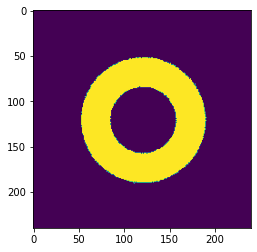

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(newTemplate)

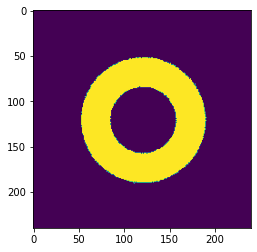

In [42]:
plt.imshow(trueTemplate)

Changes needed to `cutOutIntraExtraTemplates`:

In [1]:
import os
isrPath = os.path.join( "input", "rerun","run1","postISRCCD",)
expIds = os.listdir(os.path.join(tempWorkDir,isrPath))

extraVisitId = 9006001
intraVisitId = 9006002
extraSuffix = str(extraVisitId)[-5:]
intraSuffix = str(intraVisitId)[-5:]
print(extraSuffix, intraSuffix)
# we always generate both extra- and intra- focal
# images 
for expId in expIds:
    if extra in expId: extraExpId = expId
    elif intra in expIds:
        print('intra', intra, expId)
        intraExpId = expId 
        
intraDir = os.path.join(isrPath, intraExpId)
extraDir = os.path.join(isrPath, extraExpId )


NameError: name 'tempWorkDir' is not defined

In [12]:
expIds = ["4021123106001-g","4021123106002-g"]
extraVisitId = 9006001
intraVisitId = 9006002
extraSuffix = str(extraVisitId)[-5:]
intraSuffix = str(intraVisitId)[-5:]

for expId in expIds:
    #print(expId)
    if extraSuffix in expId: 
        extraExpId = expId
        print(extraExpId)
    elif intraSuffix in expId: 
        print(intraExpId)
        intraExpId = expId 
        

4021123106001-g
4021123106002-g


In [10]:
extraExpId

'4021123106001-g'

In [ ]:
#
"4021123106001-g","R22",
)

In [47]:

extra

'06001'

Tested the changes with running  on `lsst-devl03` 

    python bin.src/runCreatePhosimDonutTemplates.py --numOfProc 25 --detectorList "R22_S00 R22_S01"
  
     

The resulting new templates are in 

    /project/scichris/aos/ts_wep/policy/cwfs/donutTemplateData/phosimTemplates

extra_template-R22_S01.txt
extra_template-R22_S00.txt
intra_template-R22_S00.txt
intra_template-R22_S01.txt


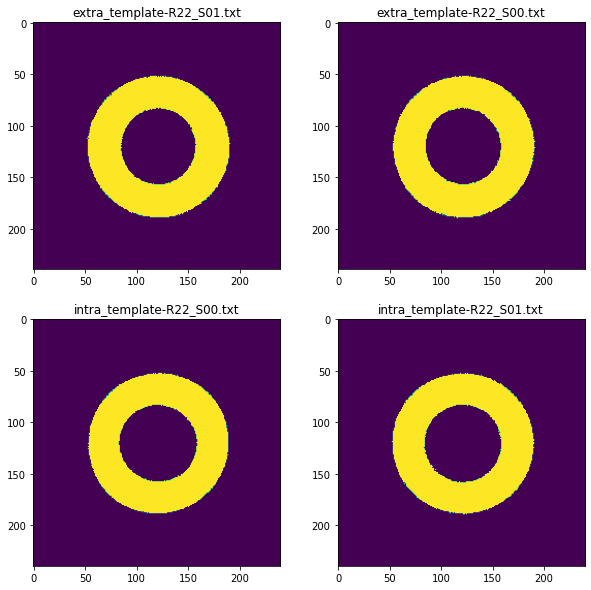

In [66]:
templateDir = '/project/scichris/aos/ts_wep/policy/cwfs/donutTemplateData/phosimTemplates'
templates = os.listdir(templateDir)
fig,axs = plt.subplots(2,2,figsize=(10,10))
ax = np.ravel(axs)
i = 0 
for templateName in templates:
    if 'template-R22' in templateName:
        print(templateName)
        image = np.genfromtxt(os.path.join(templateDir, templateName))
        ax[i].imshow(image)
        ax[i].set_title(templateName)
        i += 1 

In [58]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [59]:
fig.add_subplot()

Signature: fig.add_subplot(*args, **kwargs)
Docstring:
Add an `~.axes.Axes` to the figure as part of a subplot arrangement.

Call signatures::

   add_subplot(nrows, ncols, index, **kwargs)
   add_subplot(pos, **kwargs)
   add_subplot(ax)
   add_subplot()

Parameters
----------
*args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
    The position of the subplot described by one of

    - Three integers (*nrows*, *ncols*, *index*). The subplot will
      take the *index* position on a grid with *nrows* rows and
      *ncols* columns. *index* starts at 1 in the upper left corner
      and increases to the right.  *index* can also be a two-tuple
      specifying the (*first*, *last*) indices (1-based, and including
      *last*) of the subplot, e.g., ``fig.add_subplot(3, 1, (1, 2))``
      makes a subplot that spans the upper 2/3 of the figure.
    - A 3-digit integer. The digits are interpreted as if given
      separately as three single-digit integers, i.e.
      ``f



I do an interactive rebase to the last commit that was pushed to the PR. 


    git log 
    
      commit ddba1f4f105ad82042c85ffcc98f2adc420794f0 (HEAD -> tickets/DM-28330)
    Author: suberlak <sci.chris@gmail.com>
    Date:   Wed Mar 10 20:49:14 2021 +0000

        Update test for createPhosimDonutTemplates

    commit 1084ab4707ae5ef9c044376086609fdf0bcd438b
    Author: suberlak <sci.chris@gmail.com>
    Date:   Wed Mar 10 20:41:22 2021 +0000

        Updated CreatePhosimDonutTemplates to lsstCam

    commit 39b24e403a29df2af7920118372e1ed37ee821dc
    Author: suberlak <sci.chris@gmail.com>
    Date:   Tue Mar 9 21:47:56 2021 +0000

        Clean CreatePhosimDonutTemplates.py according to F541

    commit b9fd4b14b2e4c4f981dfd99b04a2ffc6bf000fe5
    Author: suberlak <sci.chris@gmail.com>
    Date:   Tue Mar 9 21:41:09 2021 +0000

        Cleaned DonutTemplatePhosim.py

    commit 0c0dcabf59f7bd5184a0ff2524f1c0fbcfdbafcd (origin/tickets/DM-28330)
    Author: suberlak <sci.chris@gmail.com>
    Date:   Tue Mar 9 20:30:04 2021 +0000

        Compressed intra-focal e-images
  
    
    
    git rebase -i 0c0dcab
    
shows 
    
    pick b9fd4b1 Cleaned DonutTemplatePhosim.py
    
    pick 39b24e4 Clean CreatePhosimDonutTemplates.py according to F541
    
    pick 1084ab4 Updated CreatePhosimDonutTemplates to lsstCam
    
    pick ddba1f4 Update test for createPhosimDonutTemplates

so I reorder or squash appropriately so that there is one commit per file : 


pick b9fd4b1 Clean DonutTemplatePhosim.py

pick 39b24e4 Update CreatePhosimDonutTemplates.py  to lsstCam 
squash 1084ab4 Cleaned CreatePhosimDonutTemplates.py 

pick ddba1f4 Update test_createPhosimDonutTemplates.py









# Procedure to clean up commit history for ts_wep:
    

1) rebase to the latest commit just before the first commit of the ticket branch  : 
    
    git rebase -i [latestCommintJustBeforefirstCommitOfTicketBranch]

2) squash all commits to the FIRST commit of the PR 

3) reset to put everything in clean state EXCEPT changing anything in the files (i.e. the files will have all the changes)

     git reset --soft HEAD~1
     git reset HEAD -- .

4) add / rm all test file changes as one commit . Then make single `add` , `commit` per python file 

5) push : 

    git push --force 

# `test_utility.py`

Adding a test for `getAmpImagesFromDir` : 

In [14]:
from lsst.ts.wep.Utility import getAmpImagesFromDir,getModulePath
defocalImgDir = os.path.join(
            getModulePath(),
            "tests",
            "testData",
            "phosimOutput",
            "realComCam",
            "repackagedFiles",
            "extra",
        )
# get names of amp files
ampFiles = getAmpImagesFromDir(defocalImgDir)


In [17]:
ampFiles

['MC_H_20211231_006001_R22_S10.fits', 'MC_H_20211231_006001_R22_S11.fits']

In [16]:
# assert it is a list
# https://kapeli.com/cheat_sheets/Python_unittest_Assertions.docset/Contents/Resources/Documents/index
# 
type(ampFiles)
assertIsInstance(ampFiles,list)

#

list

In [18]:
# assert the content 
#assertTrue('MC_H_20211231_006001_R22_S10.fits' in ampFiles)
#assertTrue(MC_H_20211231_006001_R22_S11.fits' in ampFiles )
'MC_H_20211231_006001_R22_S10.fits' in ampFiles


True

In [19]:
'MC_H_20211231_006001_R22_S11.fits' in ampFiles

True

In [20]:
os.listdir(defocalImgDir)

['._.DS_Store',
 'MC_H_20211231_006001_R22_S11_e.fits.gz',
 'MC_H_20211231_006001_R22_S10.fits',
 '.DS_Store',
 'MC_H_20211231_006001_R22_S11.fits',
 'MC_H_20211231_006001_R22_S10_e.fits.gz']

# Updating  versionHistory.rst:

https://github.com/lsst-ts/ts_wep/blob/tickets/DM-28330/doc/versionHistory.rst


( after merge to develop ) :

git checkout develop
git pull

 git tag -a v1.5.4 -m "Merge pull request #72 from lsst-dm/tickets/DM-28330"
    
    git tag -ln   # shows all tags 
    
    
    git push origin --tags 

needed to conform to the new file format from DM-28556 (phosim_utils), and the new geometry, gain, read noise etc. for lsstCam in focalplanelayout.txt following DM-28557 (phosim_syseng4) . This makes ts_wep compatible with the updated gain / read noise values in obs_lsst for lsstCam from DM-28553.



Need to update the tag (move it to a later commit):

     git checkout develop # to get the most recent updates from develop 
     git pull --tags # to get all the tags 

     git tag -d v1.5.4  # to delete the tag
     git push origin :refs/tags/v1.5.4  # to delete the tag in the remote

     git tag -fa v1.5.4 # to make  the tag with that name 

     git push -f --tags # to forcefully push this tag 

 Another way  : 
 
     git tag -fa v1.5.4 -m "Update to LsstCamMapper"
     git push -f --tags     #  
     
     

In [ ]:
Update test files with ROTANG